Best predictors for survival in the titanic dataset

Boat: onloy those who survived were given boats
Class: lower class = more survivability
Sex: women survived more
Age: younger people survived ore
Fare: higher fare meant higher survival chance

In [2]:
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as pt
import seaborn as sns
import numpy as np

In [32]:
path = "/home/mycicle/git/advTimeSeriesMachineLearning/dataSets/titanic.csv"
df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1308
Data columns (total 5 columns):
survived    1045 non-null float64
pclass      1045 non-null float64
sex         1045 non-null object
age         1045 non-null float64
fare        1045 non-null float64
dtypes: float64(4), object(1)
memory usage: 49.0+ KB


,survived,pclass,age,fare
count,1045.000000,1045.000000,1045.000000,1045.000000
mean,0.408612,2.206699,29.851834,36.686080
std,0.491813,0.841542,14.389201,55.732533
min,0.000000,1.000000,0.166700,0.000000
25%,0.000000,1.000000,21.000000,8.050000
50%,0.000000,2.000000,28.000000,15.750000
75%,1.000000,3.000000,39.000000,35.500000
max,1.000000,3.000000,80.000000,512.329200


In [33]:
#a fare of over 400 is waaaay above the mean, it represents a serious outlier
df = df[df.fare < 400]
target_feature = df["survived"]
predictor_features = df[["pclass", "sex", "age", "fare"]]
predictor_features.head(5)

,pclass,sex,age,fare
0,1.0,female,29.0000,211.3375
1,1.0,male,0.9167,151.5500
2,1.0,female,2.0000,151.5500
3,1.0,male,30.0000,151.5500
4,1.0,female,25.0000,151.5500


In [34]:
df["female"] = (df.sex=="female").astype(int)
df.head(5)

,survived,pclass,sex,age,fare,female
0,1.0,1.0,female,29.0000,211.3375,1
1,1.0,1.0,male,0.9167,151.5500,0
2,0.0,1.0,female,2.0000,151.5500,1
3,0.0,1.0,male,30.0000,151.5500,0
4,0.0,1.0,female,25.0000,151.5500,1


In [35]:
nonmetric_predictors = df[["pclass", "female"]]
metric_predictors = df[["age", "fare"]]

We have:
<br>
nonmetric_predictors
<br>
metric_predictors
<br>
and predictor_features

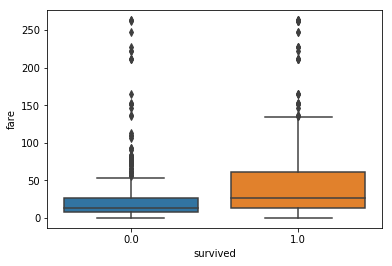

In [36]:
sns.boxplot("survived", "fare", data=df)

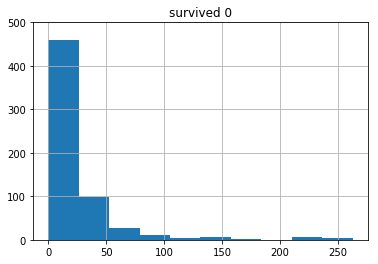

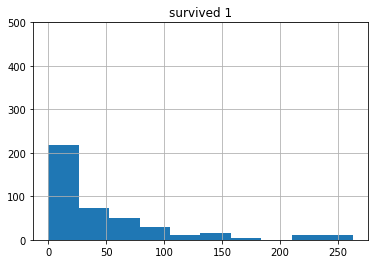

In [37]:
#for 0 and 1
for i in range(2):
    #the dataframe is all of the dead people or all of the alive people
    #make a histogram displaying the relative frequencies of different fairs
    hist = df[df.survived == i].hist("fare")
    pt.title("survived " + str(i))
    pt.ylim(0,500)
    pt.show()

The above plot shows that higher faires do correlate with higher survival rates

Time to quantify entropy and information gain for the different metrics to get a more mathematical understanding of what is going on

In [98]:
def entropy(target_column):
    """
    computes the entropy equation for a certain column 
    sum(-sum(i)/total * ln(sum(i)/total)) for all i
    """
    
    #get the counts of each target variable
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    #compute a list of the probabilities of each target variable
    probas = target_counts / total
    #compute the entropy and store it in a list
    entropy_components = -probas * np.log2(probas)
    
    #return the sum of all of those entropy components
    return entropy_components.sum()
def informationGain(df, info_column, target_column, threshold):
    """
    computes information gain of an info column with a certain threshold
    IG = H(target_column) - (info > threshold) / total# *H(info>threshold)
                          - (info <= threshold) / total# * H(info<= threshold)
    """
    
    #first split the data into above threshold and below threshold
    above_threshold = df[df[info_column] > threshold]
    below_threshold = df[df[info_column] <= threshold]
    
    #calculate the entropy of the target
    target_entropy = entropy(df[target_column])
    
    #calculate entropy of the info above and below the threshold
    entropy_above = entropy(above_threshold[target_column])
    entropy_below = entropy(below_threshold[target_column])
    
    #weights of the entropys
    total = df[info_column].count()
    above_weight = above_threshold[target_column].count() / total
    below_weight = below_threshold[target_column].count() / total
    
    #compute IG
    information_gain = target_entropy - above_weight*entropy_above - below_weight*entropy_below
    
    return information_gain

Now lets test to see if fair really effects the entropy in a meaningful way

In [62]:
threshold = 50
prior_entropy = entropy(df.survived)
prior_entropy

0.9745386846013939

In [99]:
IG = informationGain(df, "fare", "survived", threshold)
IG

0.055439305962422414